In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.model_selection import (
    cross_validate,
    train_test_split,
)

In [2]:
cols =[
 'fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'type'
]

In [3]:
wine = pd.read_csv("../data/wine_data.csv")[cols]
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
train_df, test_df = train_test_split(wine, test_size=0.3, shuffle=True, random_state=123)

In [6]:
train_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
2457,6.7,0.22,0.39,10.2,0.038,60.0,149.0,0.99725,3.17,0.54,10.0,7,white
524,9.2,0.43,0.49,2.4,0.086,23.0,116.0,0.99760,3.23,0.64,9.5,5,red
4551,6.1,0.27,0.25,1.8,0.041,9.0,109.0,0.99290,3.08,0.54,9.0,5,white
5954,6.4,0.31,0.28,2.5,0.039,34.0,137.0,0.98946,3.22,0.38,12.7,6,white
3759,6.0,0.33,0.38,9.7,0.040,29.0,124.0,0.99540,3.47,0.48,11.0,6,white


In [7]:
X_train = train_df.drop(columns=["type"])
X_test = test_df.drop(columns=["type"])
y_train = train_df["type"]
y_test = test_df["type"]

In [8]:
# 2. Transformations if needed
categorical_features = ["type"]
ordinal_features = ["quality"]
numerical_features = [col for col in wine.columns if col != "type" and col != "quality"]

preprocessor = make_column_transformer(
    (OrdinalEncoder(dtype=int), ordinal_features),
    (StandardScaler(), numerical_features),
    remainder='passthrough' 
)

In [9]:
pipe = make_pipeline(
    preprocessor, 
    LogisticRegression(random_state=123, max_iter=1000, class_weight="balanced"),
)

In [10]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'>),
                                                  ['quality']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=123))])

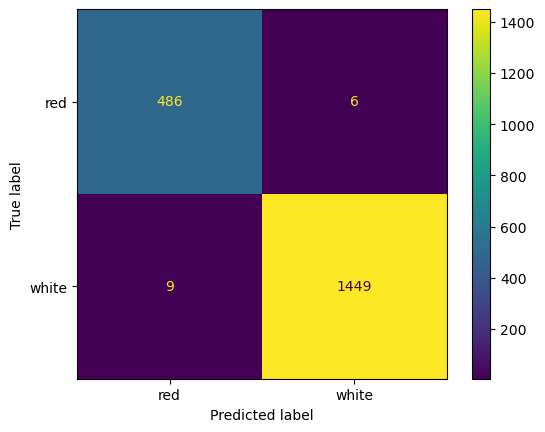

In [11]:
ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_test,
    y_test,
    values_format="d",  # Show the full number 59,700 instead of 6e+04,
)

In [12]:
pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5)
).agg(['mean', 'std']).round(3).T

,mean,std
fit_time,0.009,0.001
score_time,0.002,0.000
test_score,0.994,0.002
train_score,0.994,0.001


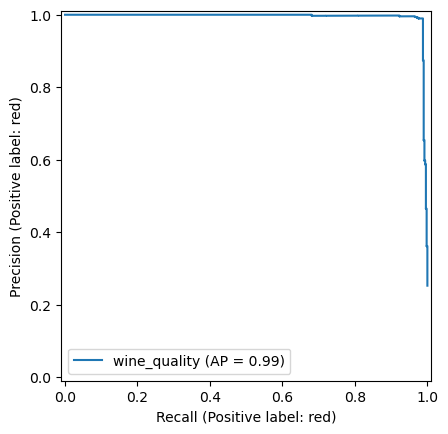

In [13]:
PrecisionRecallDisplay.from_estimator(
    pipe,
    X_test,
    y_test,
    pos_label="red",
    name='wine_quality',  # Support Vector Classifier
)